In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from sklearn.ensemble import IsolationForest
import numpy as np

In [26]:
# Read data and set timestamp as index:S
data = pd.read_parquet("data/solar_generation.parquet")
data = data.set_index("dtm")

In [27]:
data.head()

plantId        sourceKey  pow_dc  pow_ac  yield_daily  \
dtm                                                                          
2020-05-15 00:00:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 00:15:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 00:30:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 00:45:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   
2020-05-15 01:00:00  4135001  1BY6WEcLGh8j5v7     0.0     0.0          0.0   

                     yield_total  temp_ambient  temp_module  irradiation  \
dtm                                                                        
2020-05-15 00:00:00    6259559.0     25.184316    22.857507          0.0   
2020-05-15 00:15:00    6259559.0     25.084589    22.761668          0.0   
2020-05-15 00:30:00    6259559.0     24.935753    22.592306          0.0   
2020-05-15 00:45:00    6259559.0     24.846130    22.360852          0.0   
2020-05-15 01:00:00    6259559.0     24.621525    22.165423          0.0   

                     time_local  
dtm                              
2020-05-15 00:00:00        0.00  
2020-05-15 00:15:00        0.25  
2020-05-15 00:30:00        0.50  
2020-05-15 00:45:00        0.75  
2020-05-15 01:00:00        1.00

# Re-sample daily:

In [28]:
cols_resample = ["pow_dc", "pow_ac", "yield_daily", "yield_total", "temp_ambient", "temp_module", "irradiation"]
df = data.groupby("sourceKey")[cols_resample].resample("D").mean()
df = df.reset_index()

In [29]:
sources = df["sourceKey"].unique()

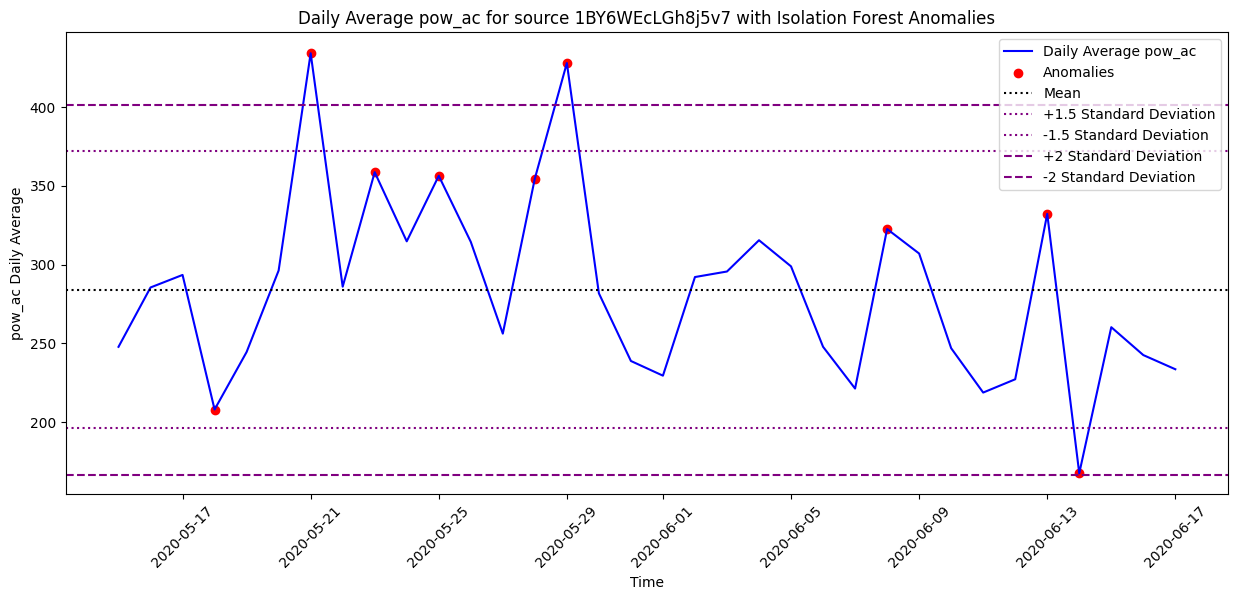

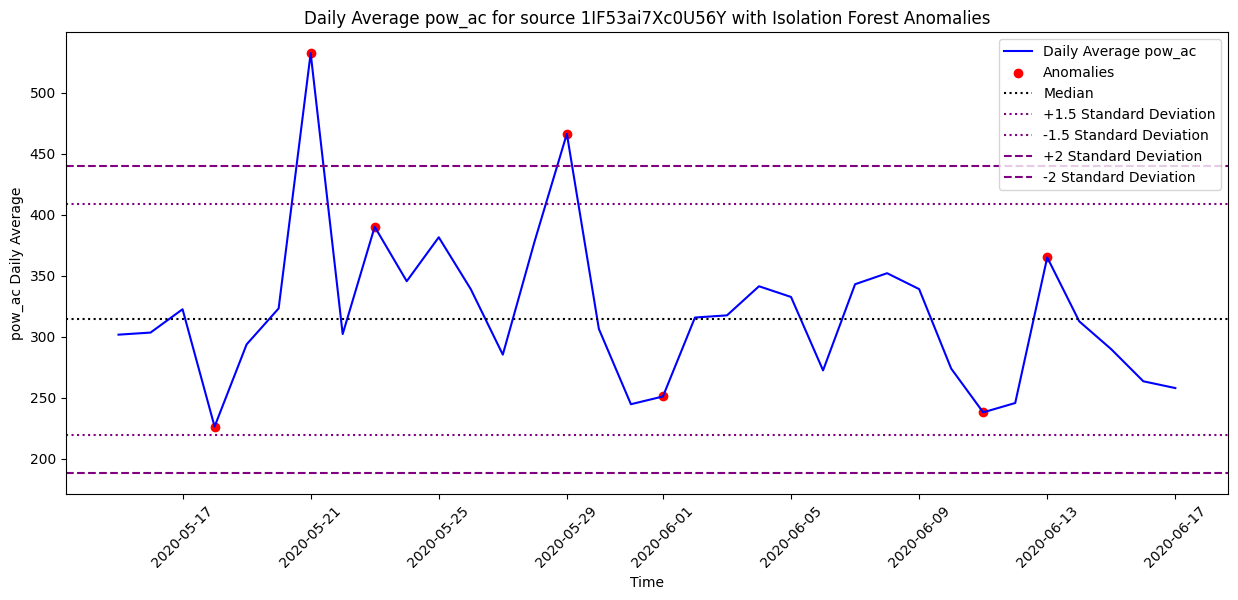

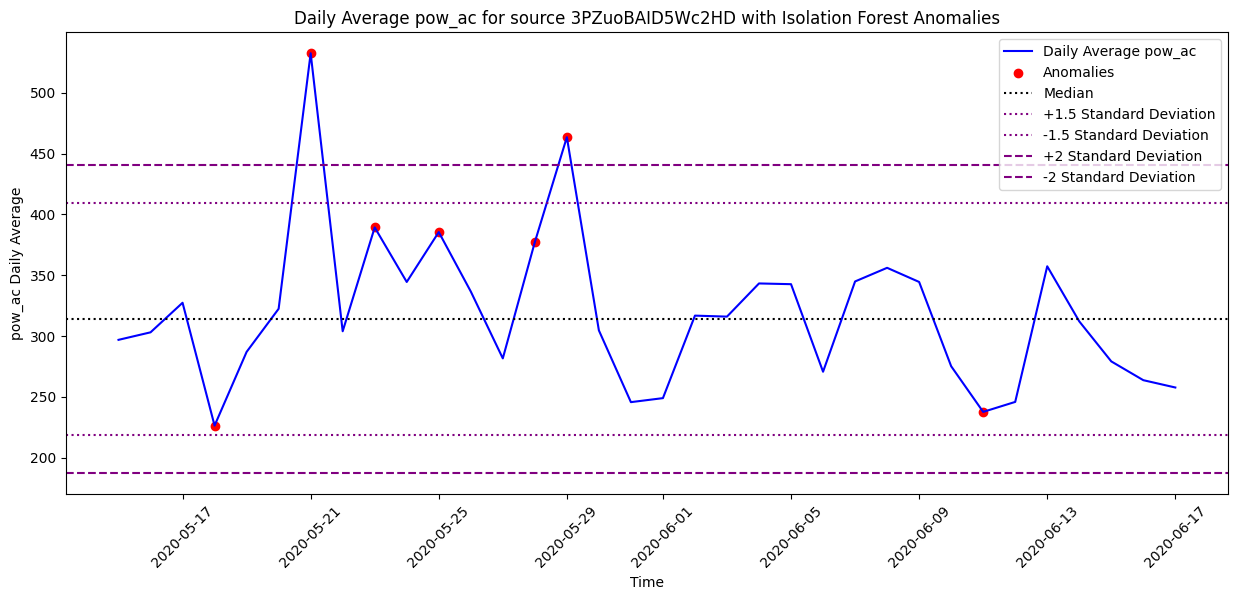

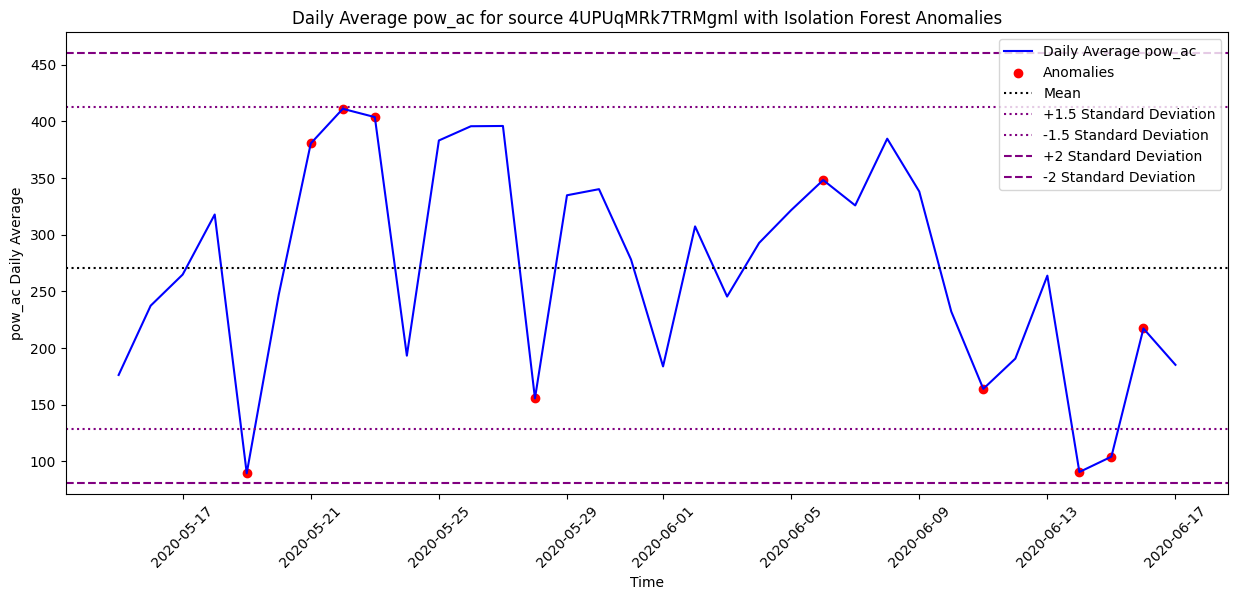

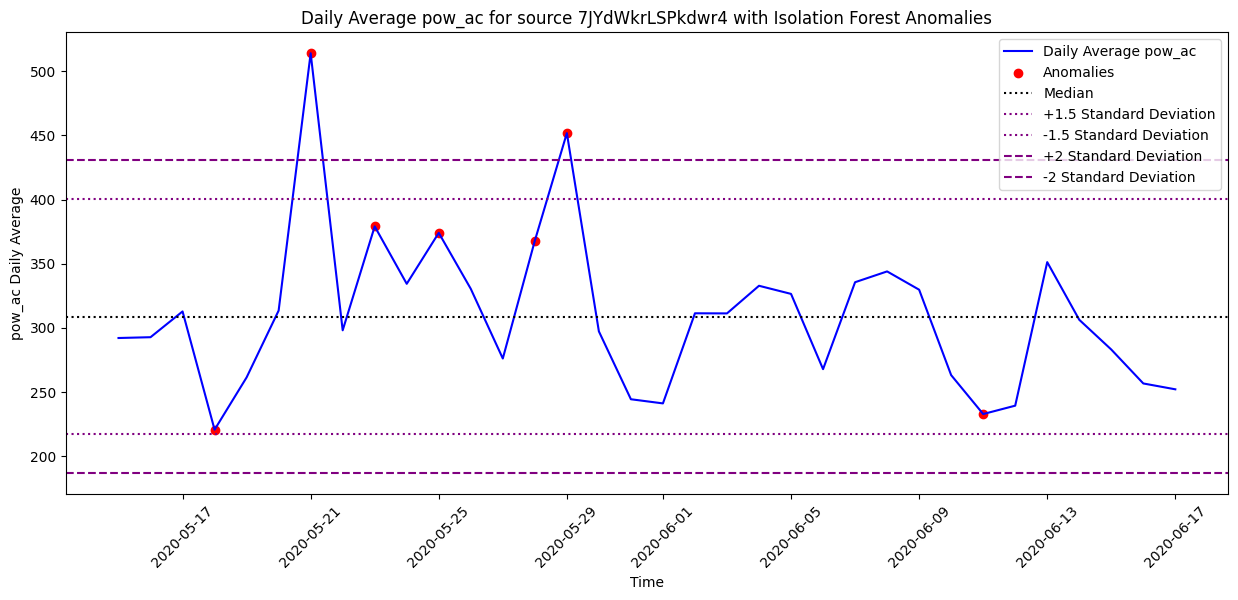

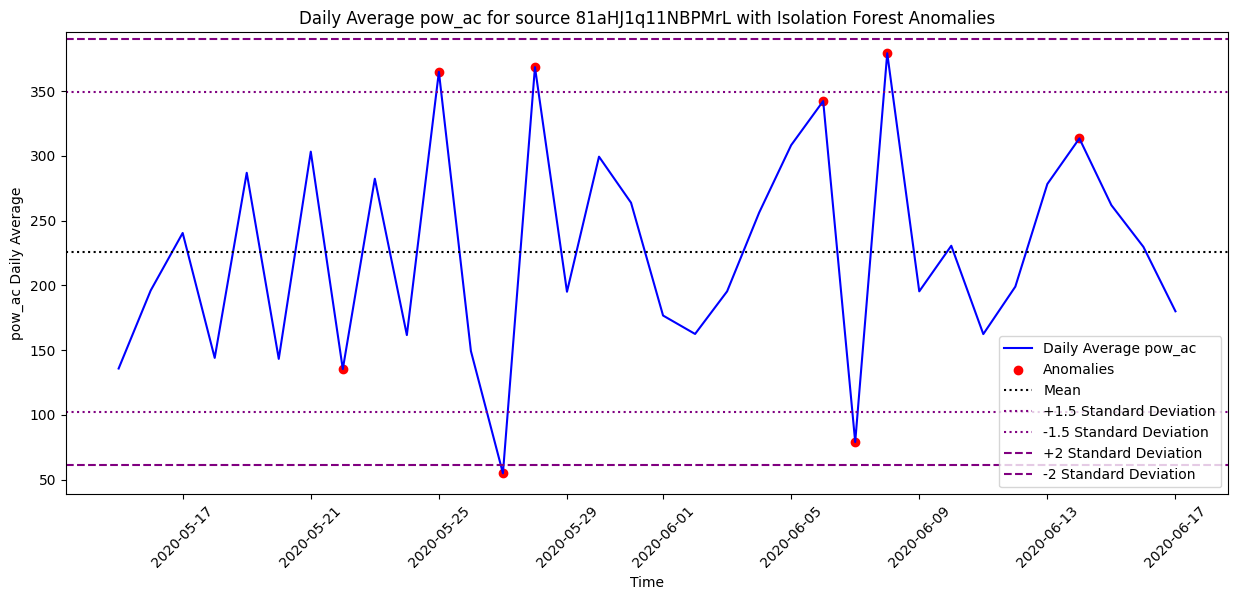

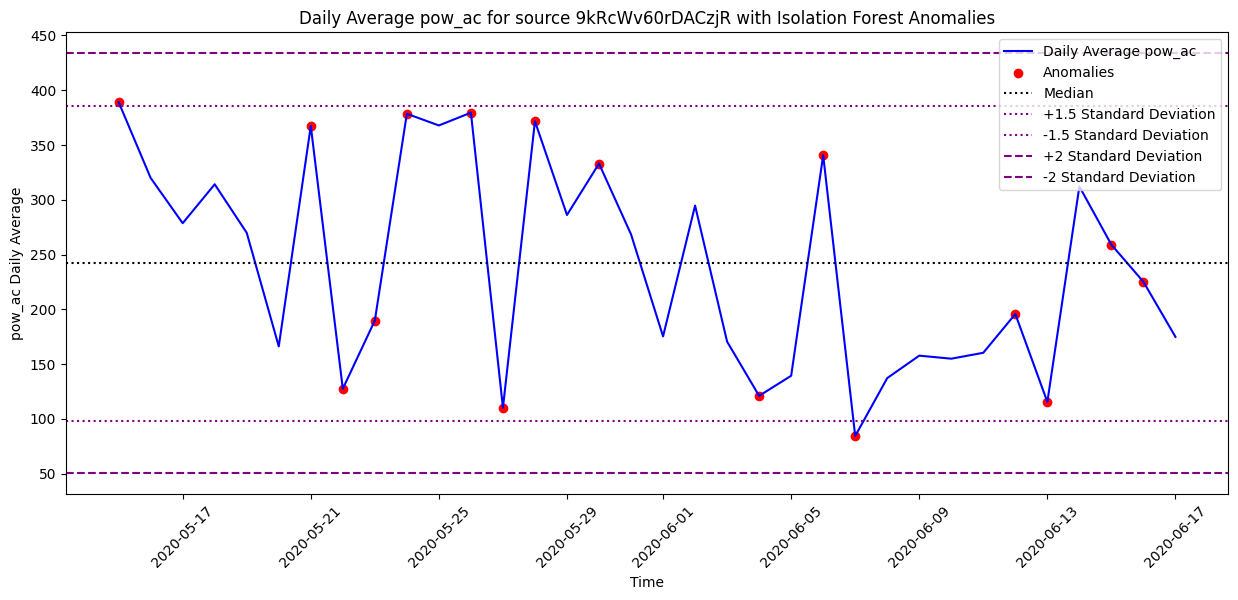

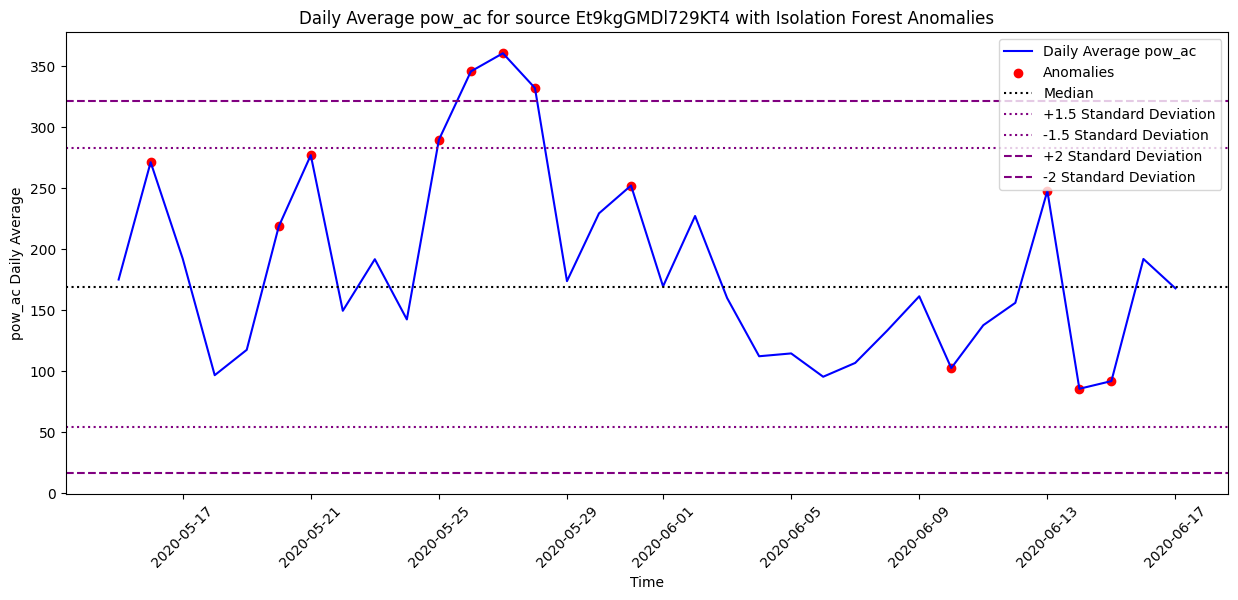

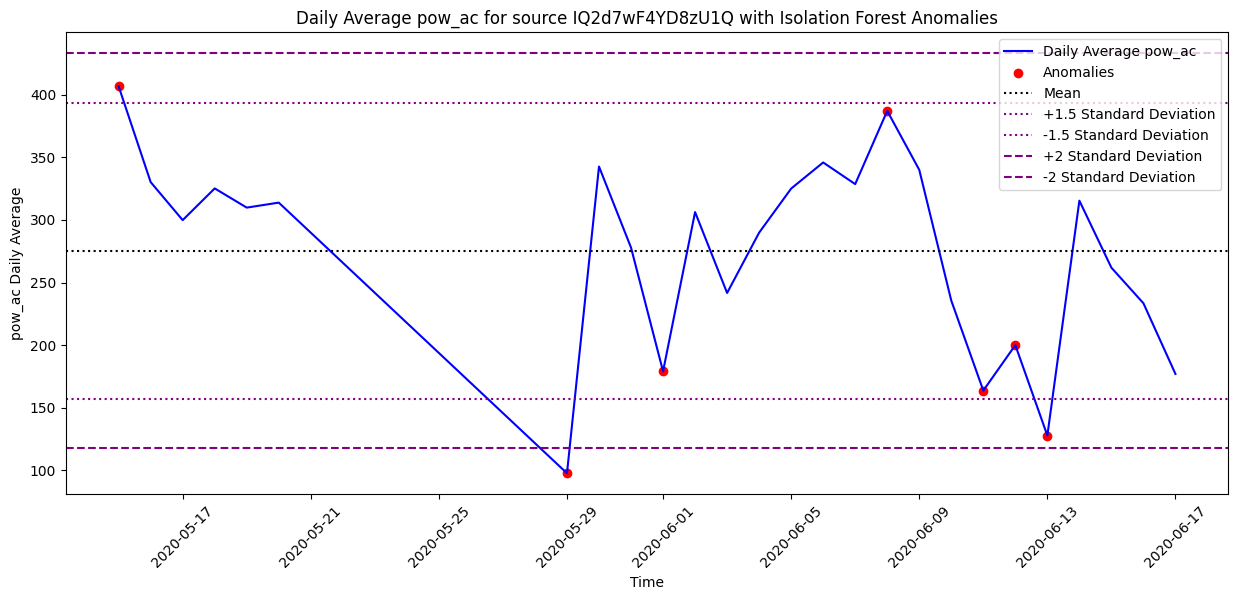

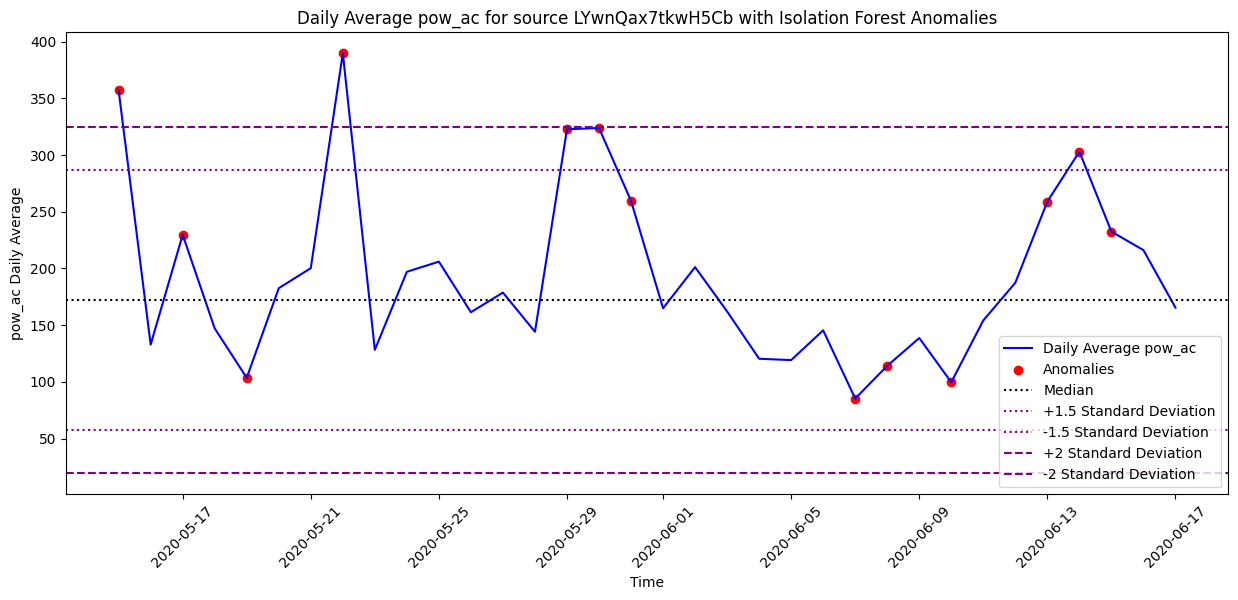

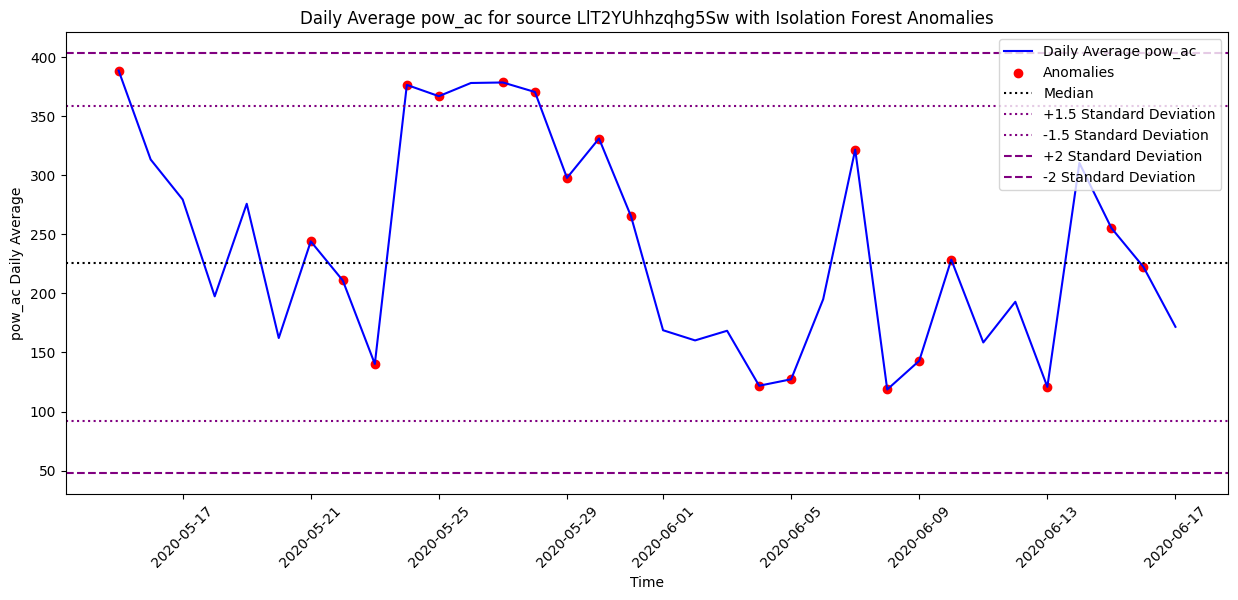

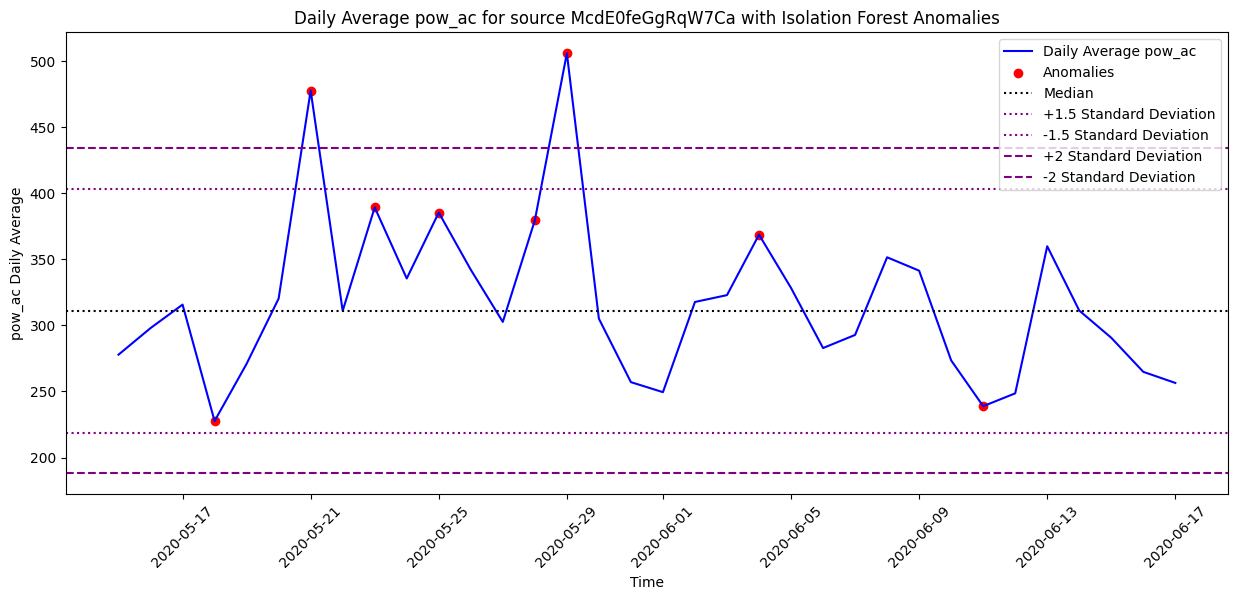

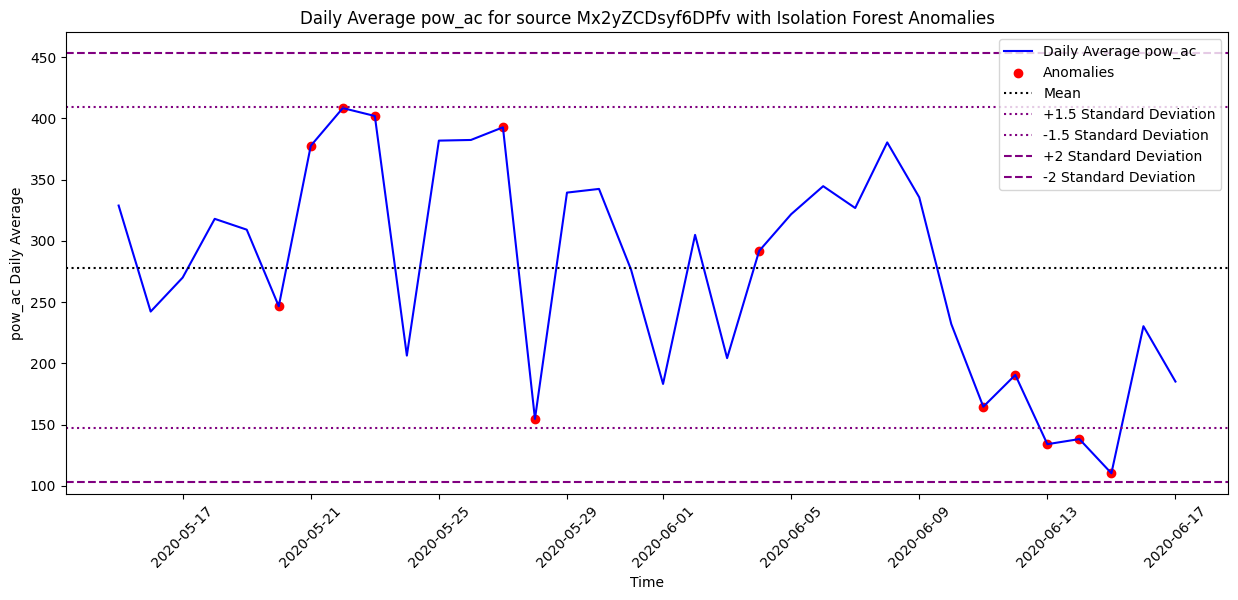

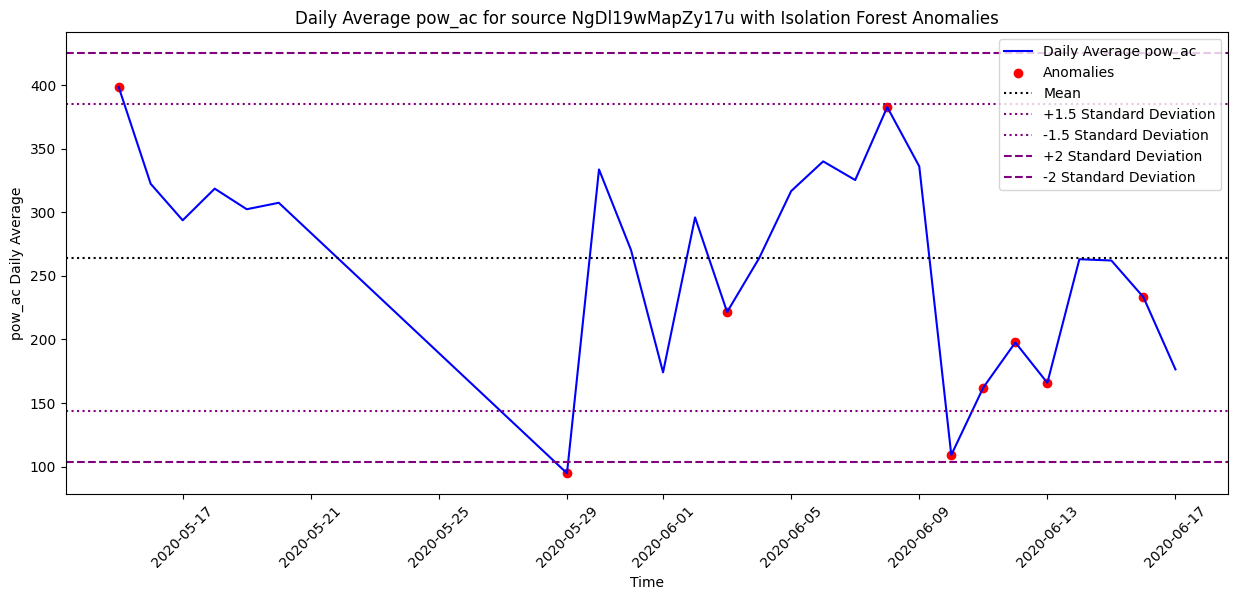

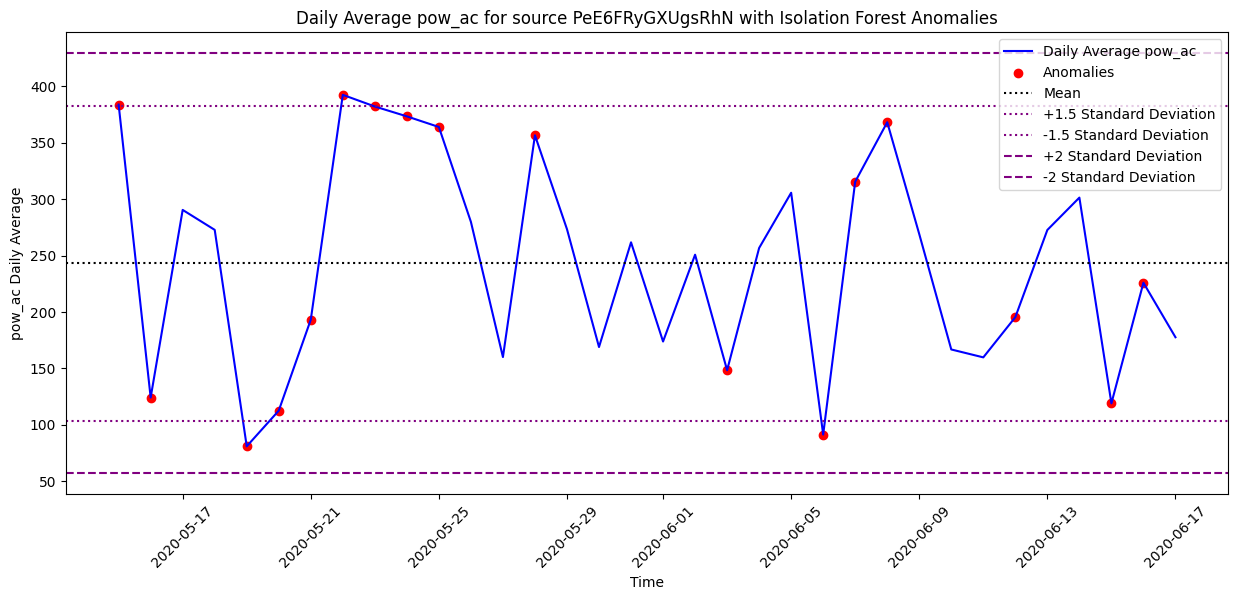

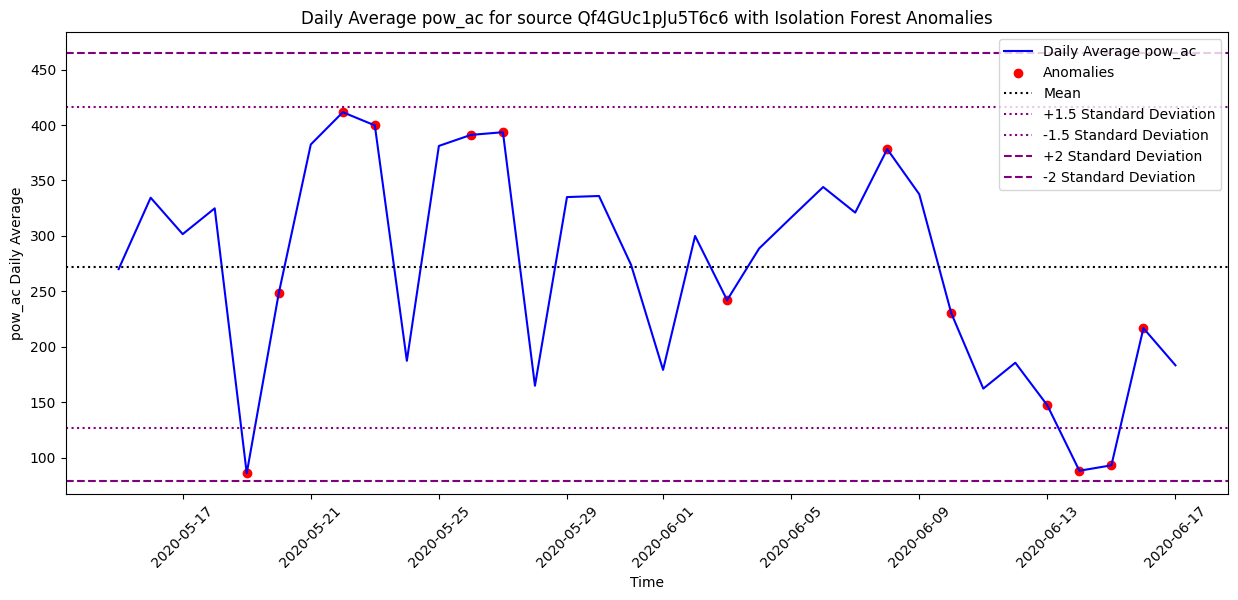

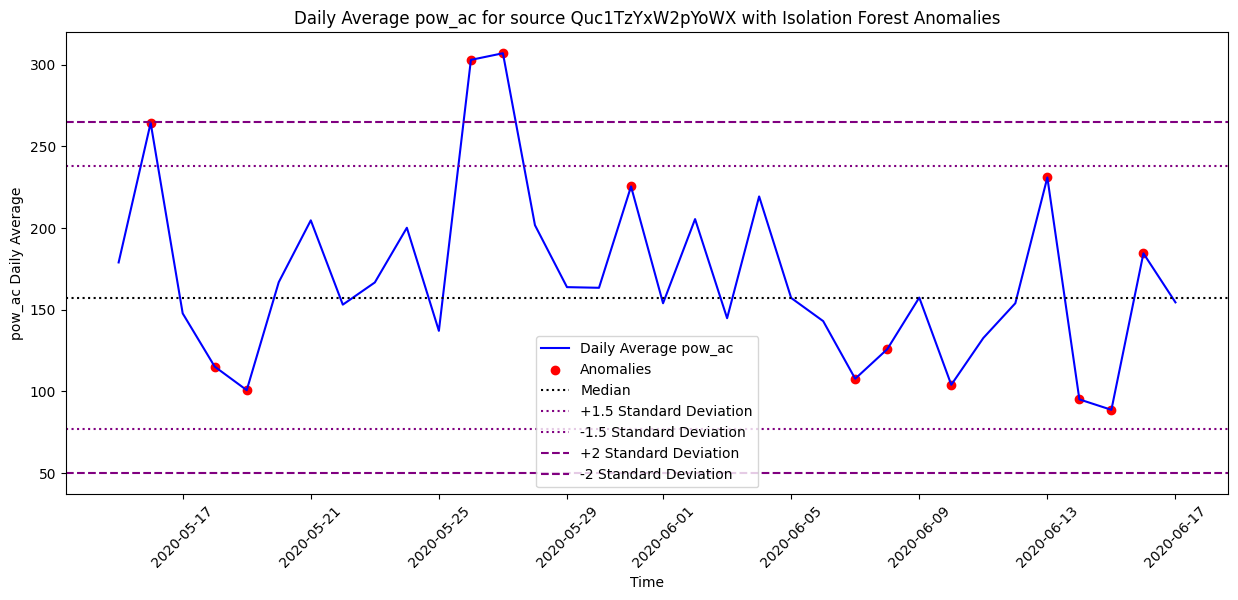

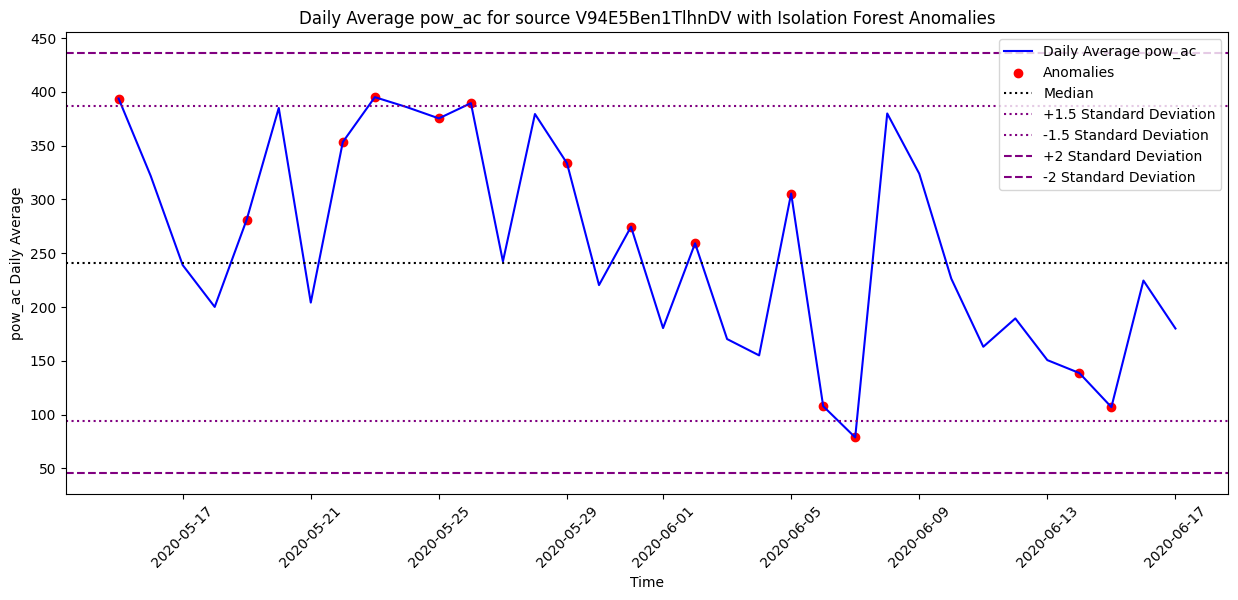

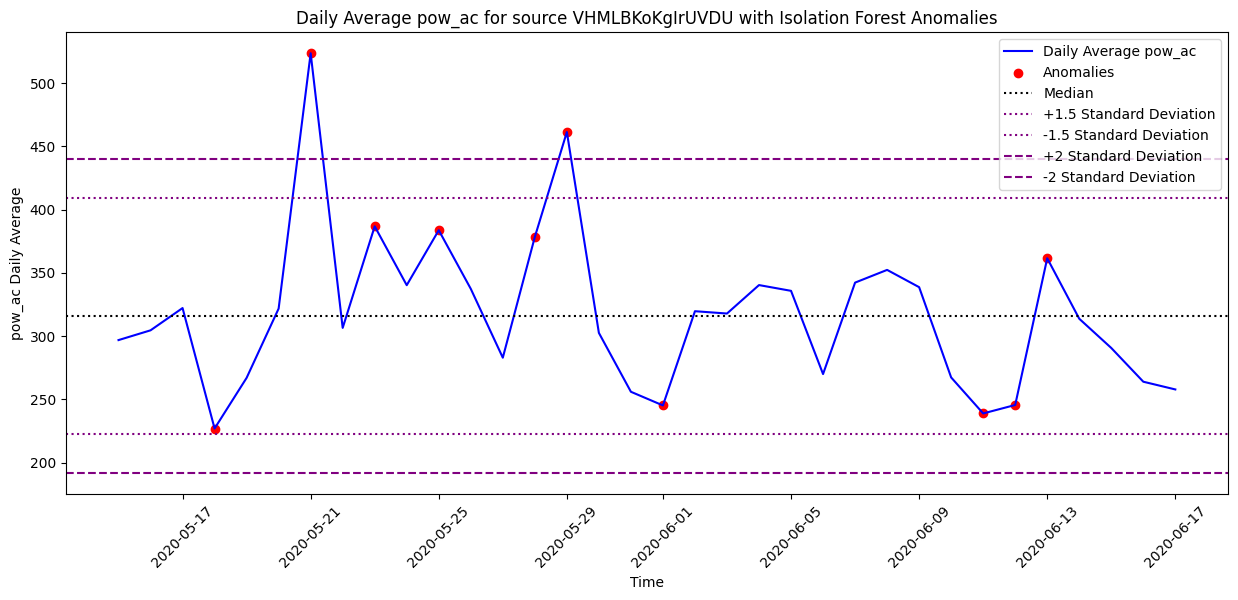

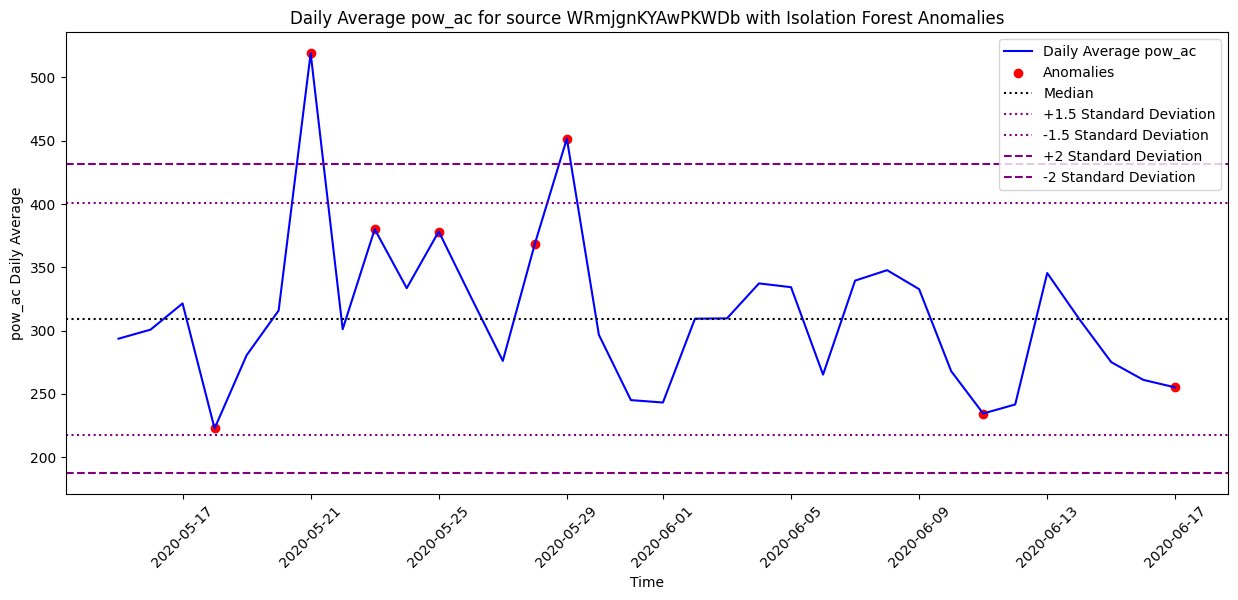

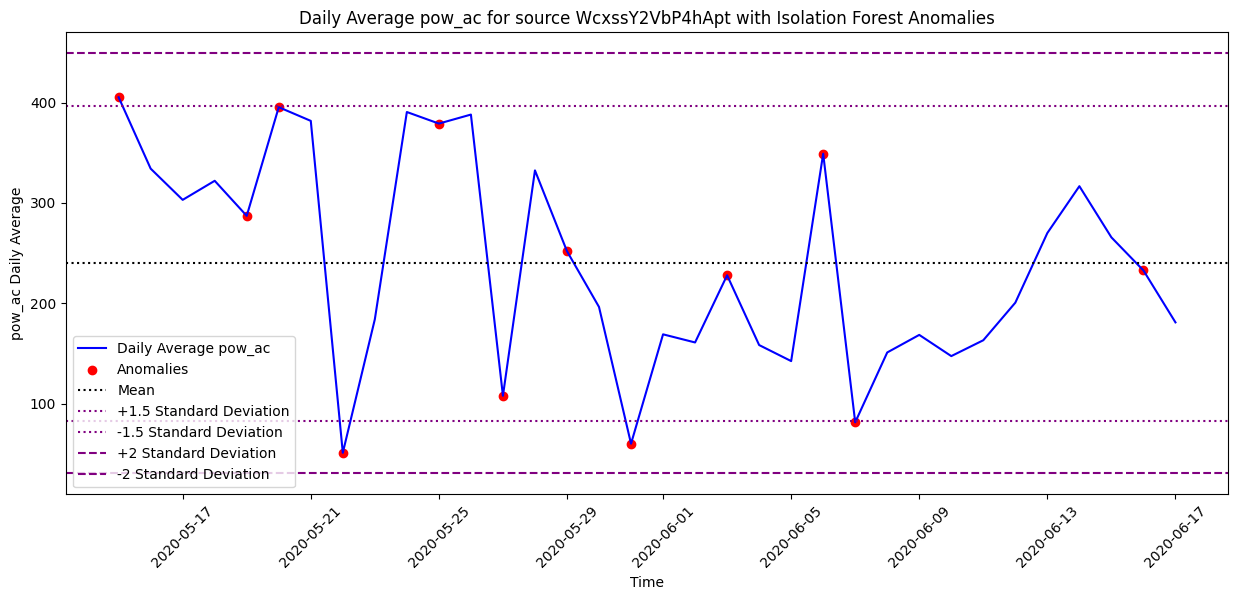

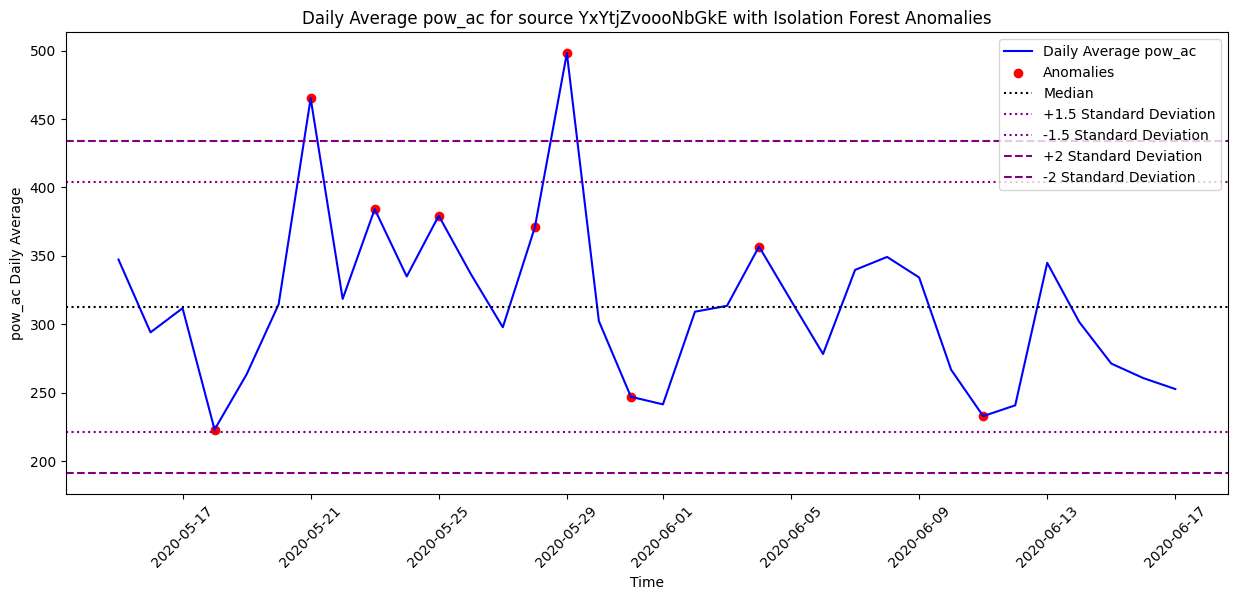

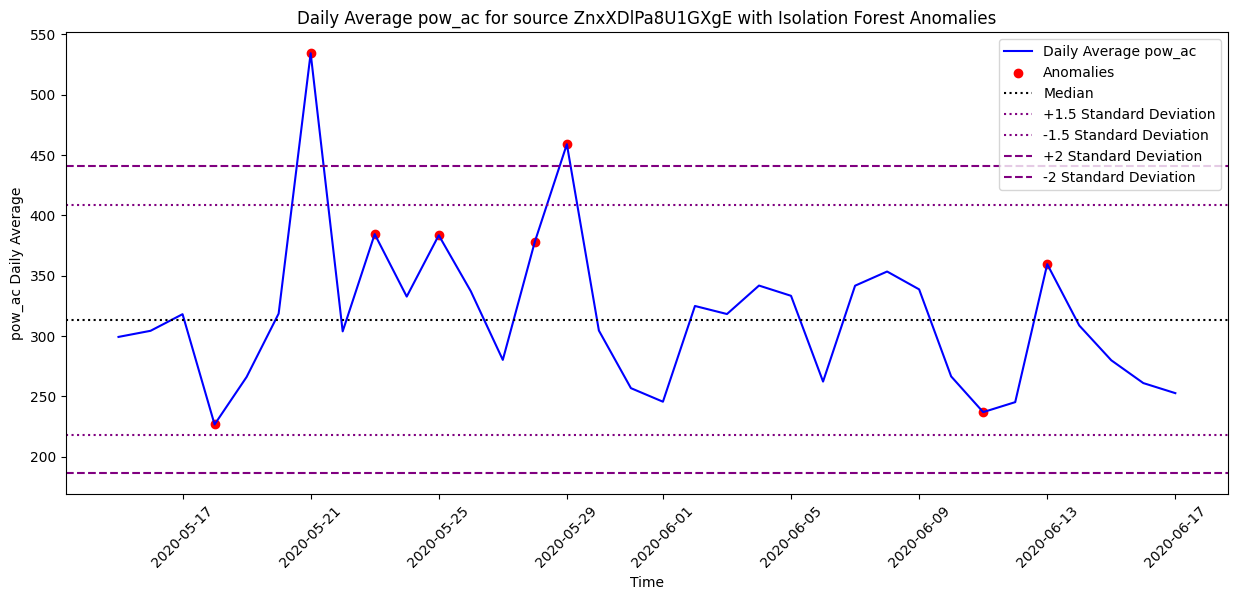

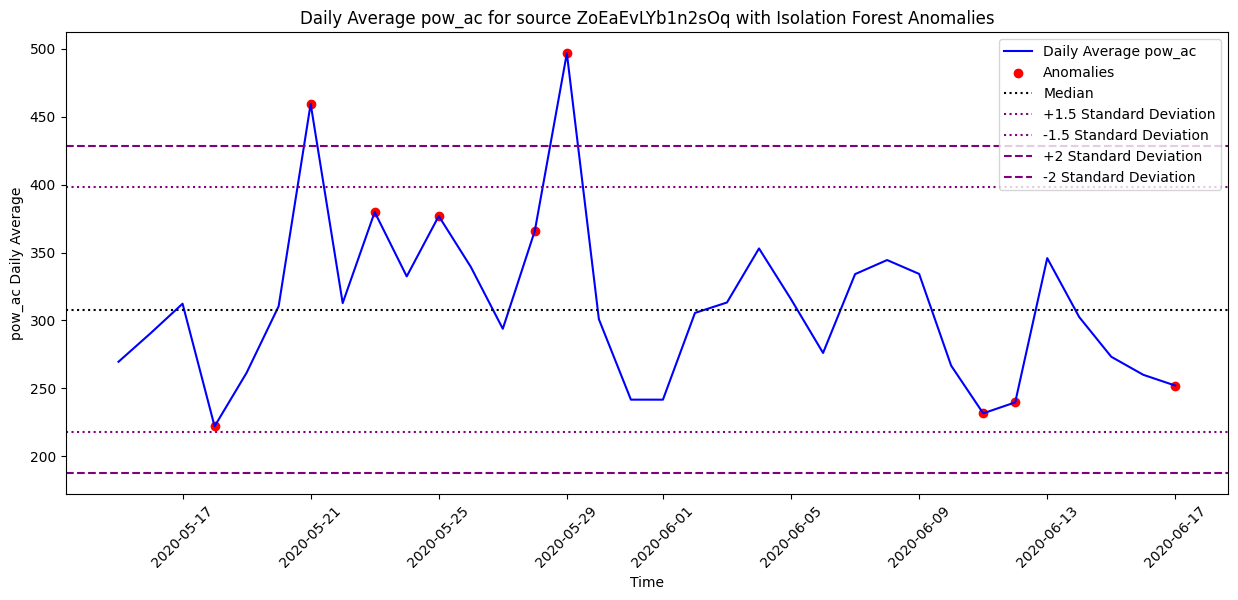

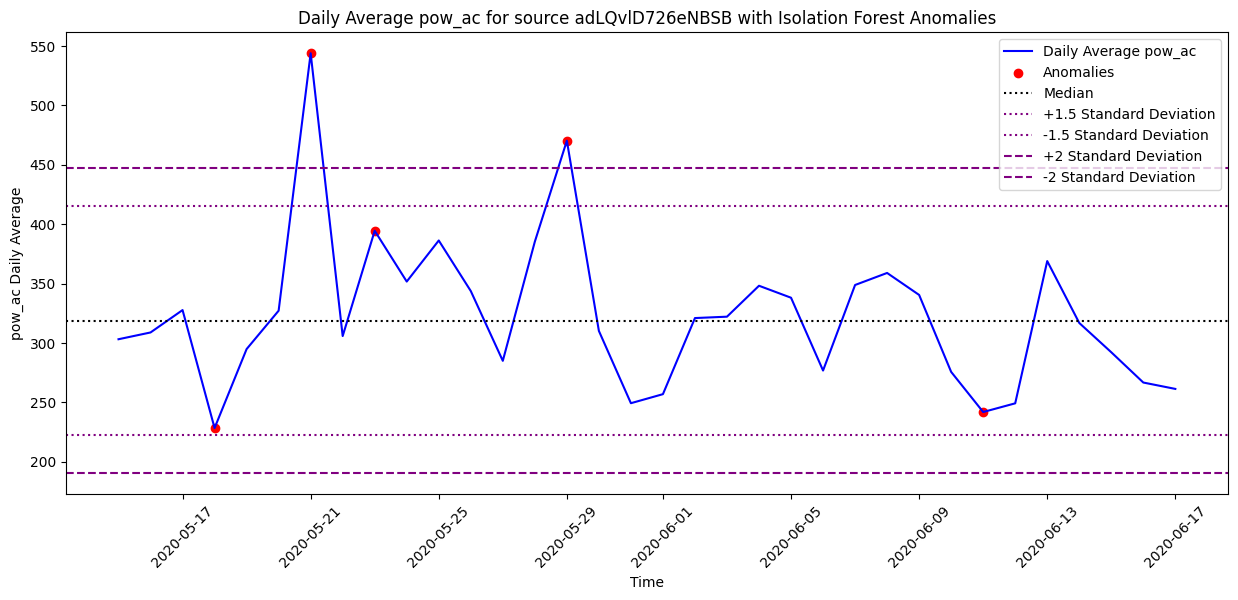

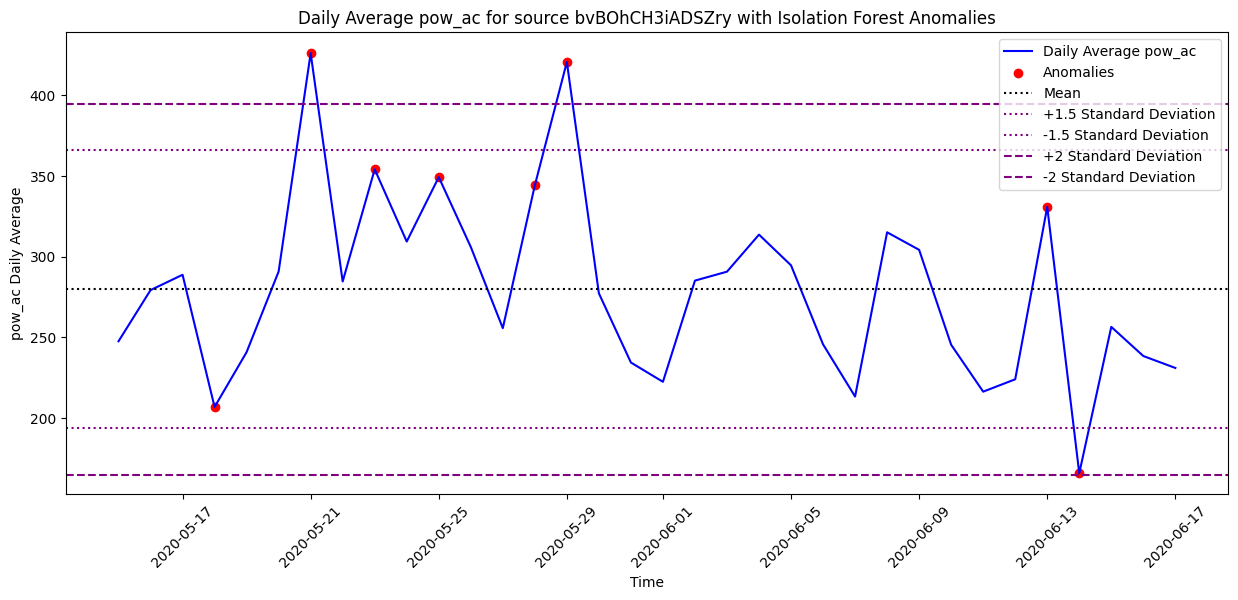

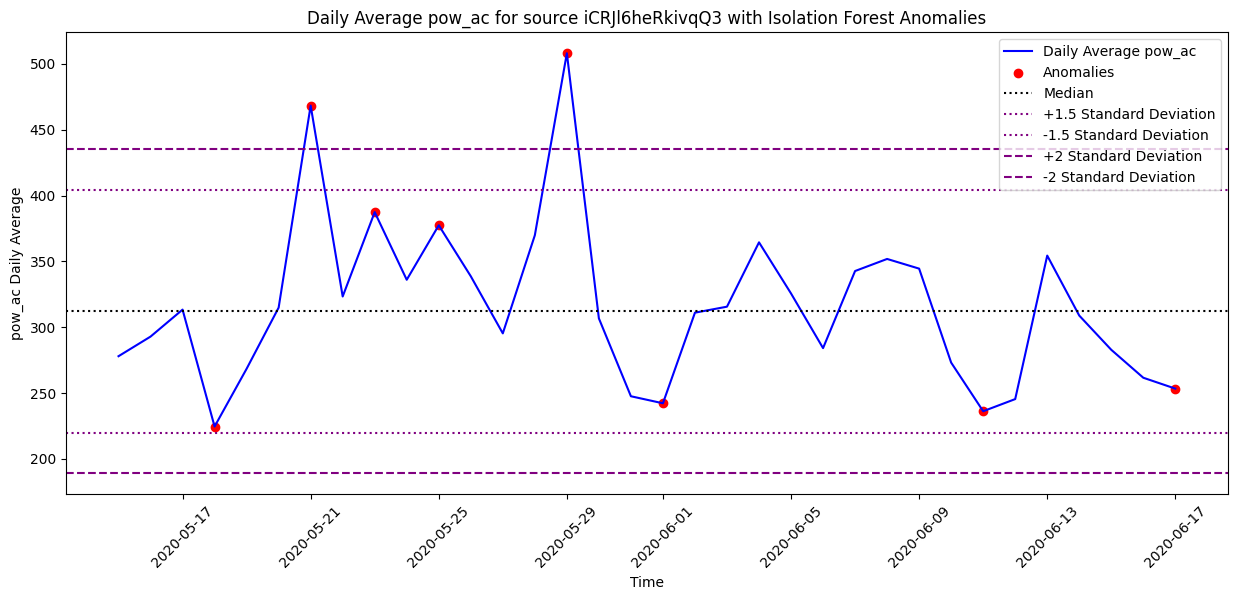

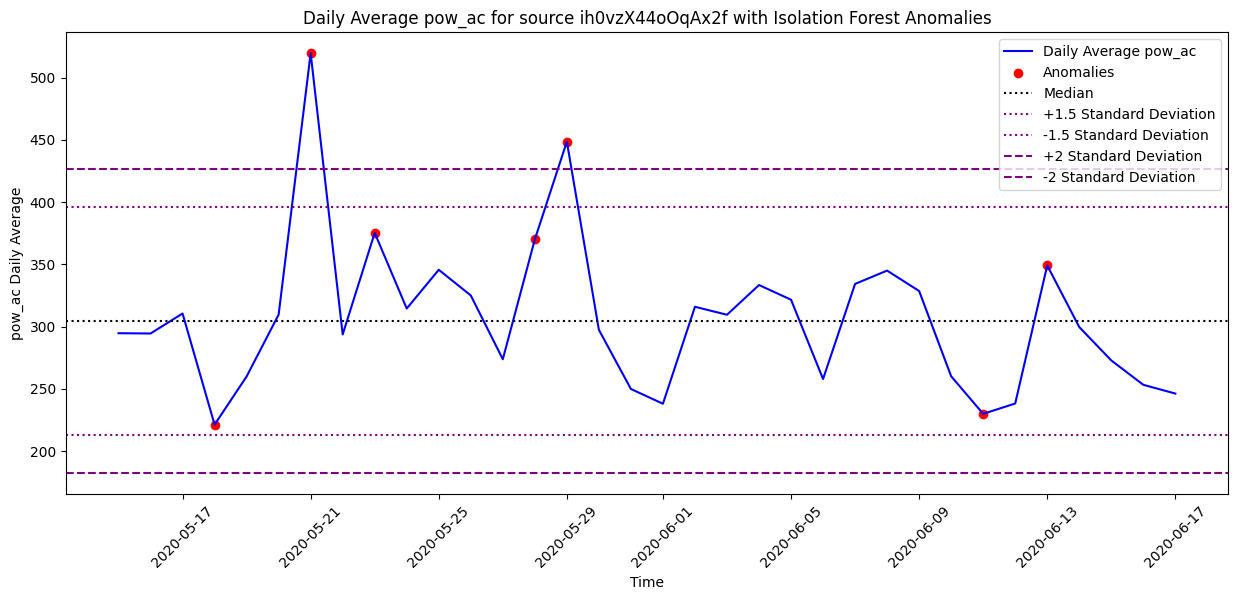

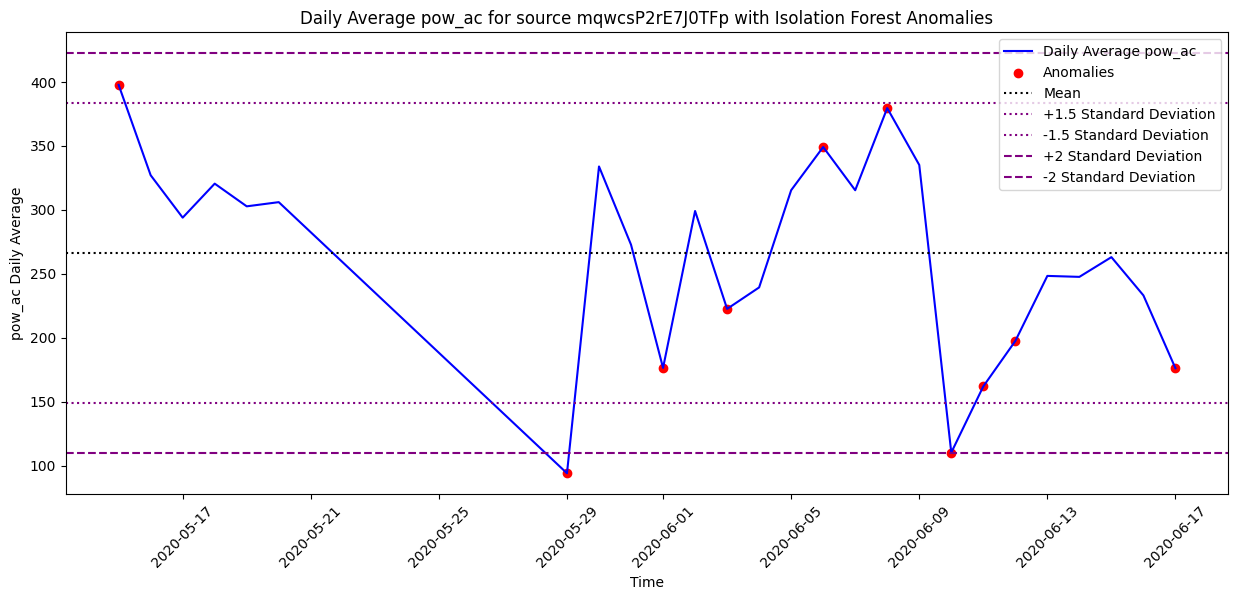

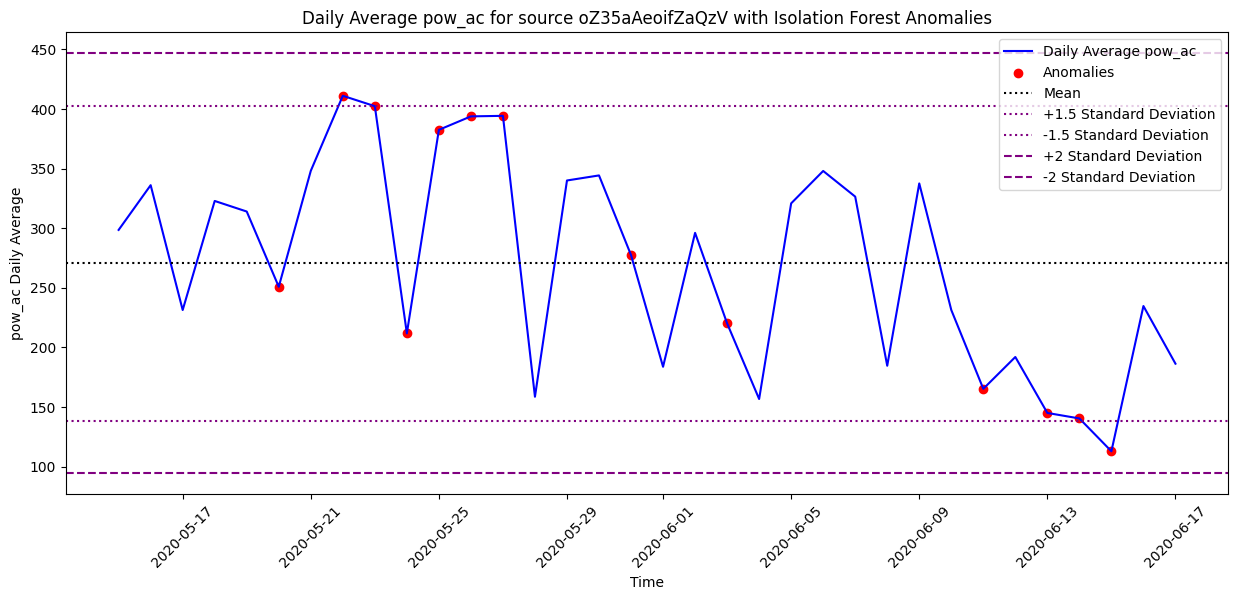

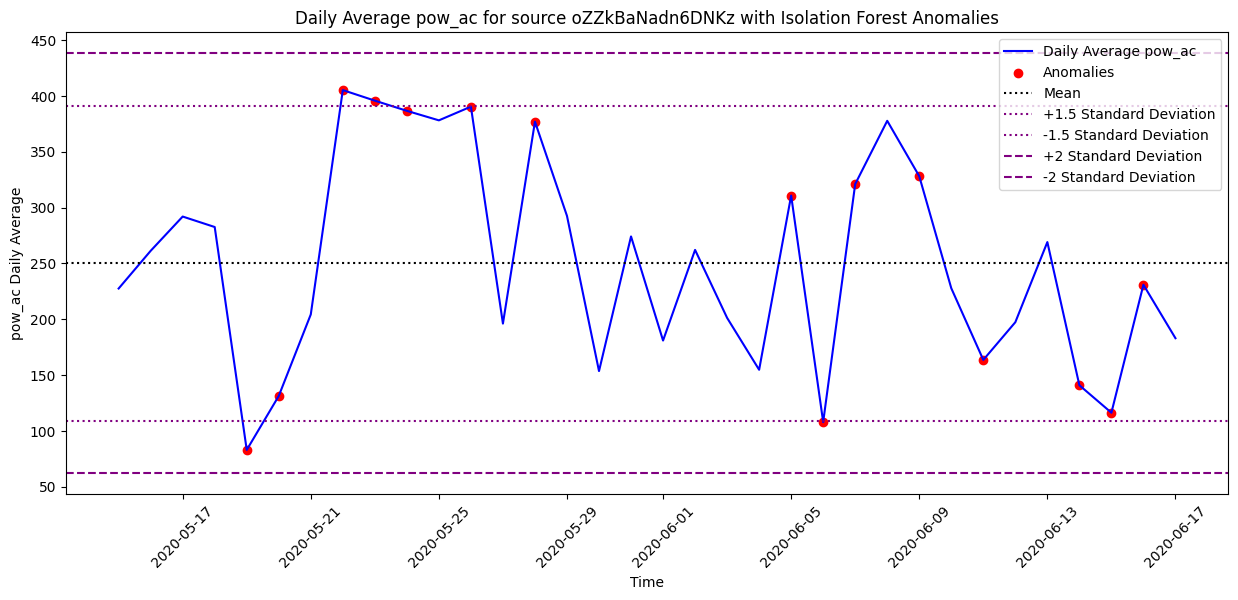

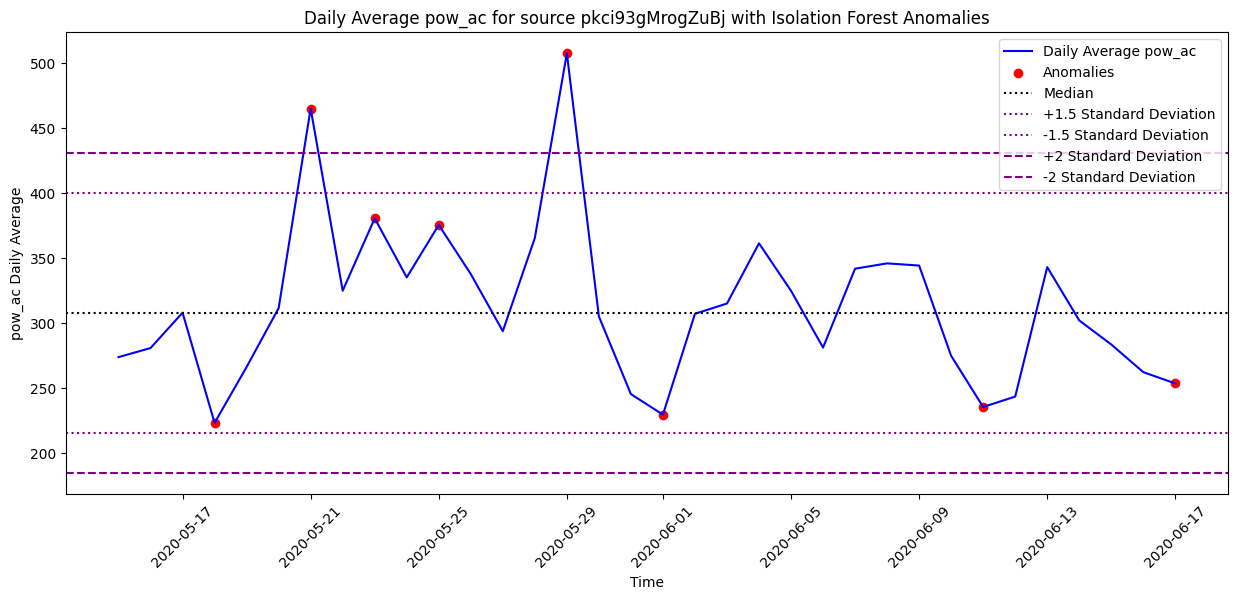

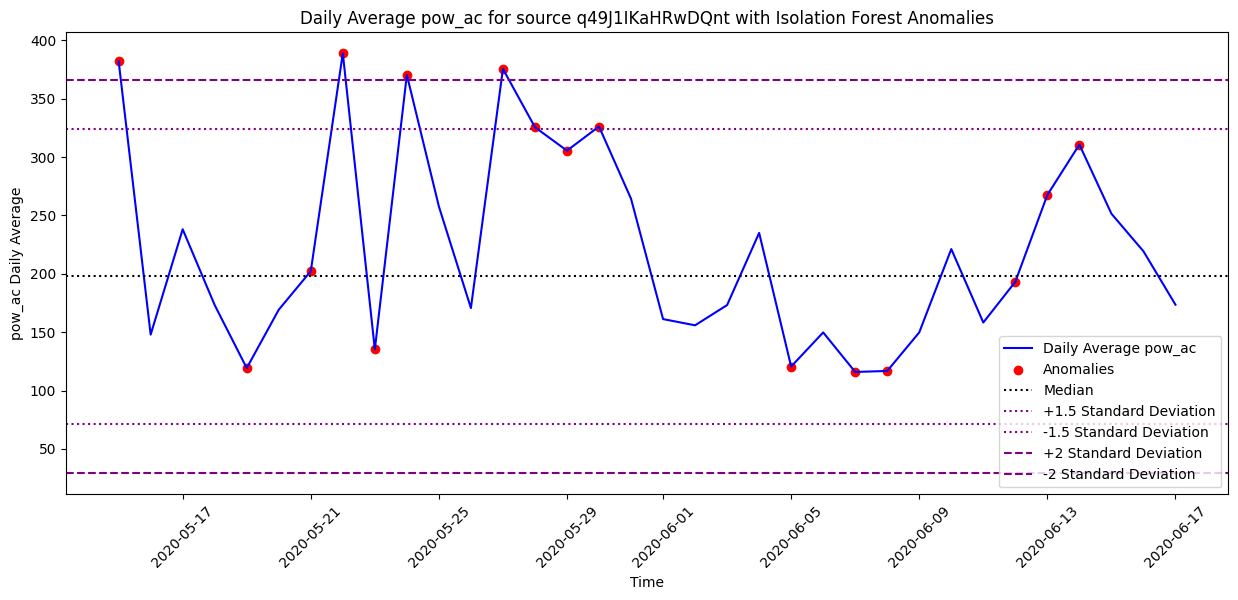

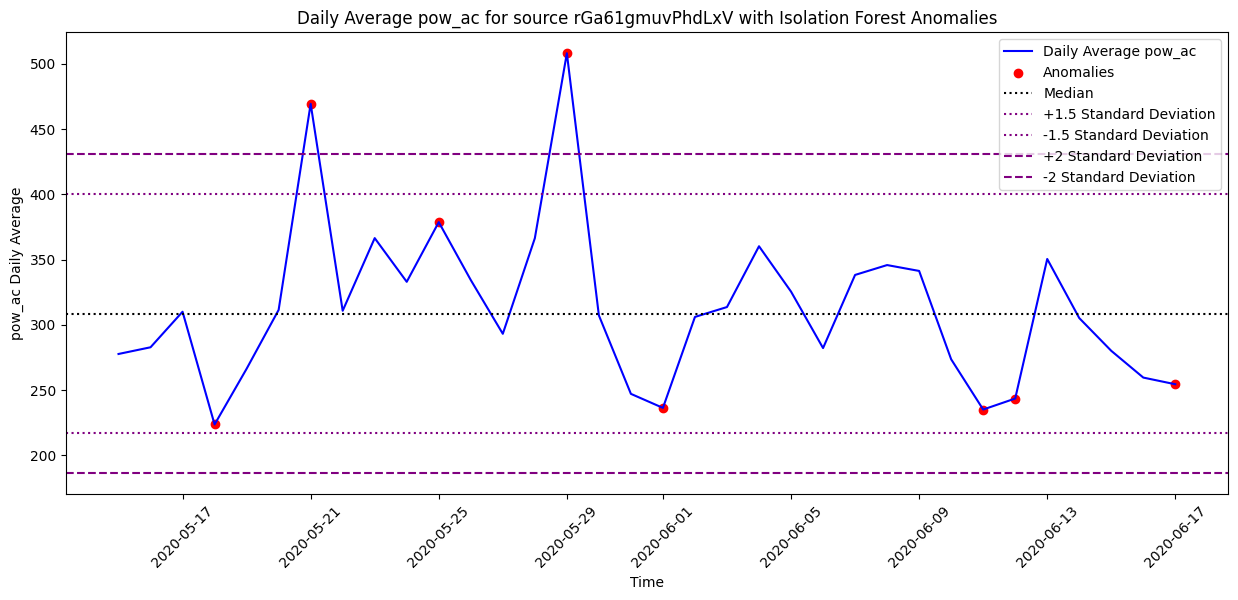

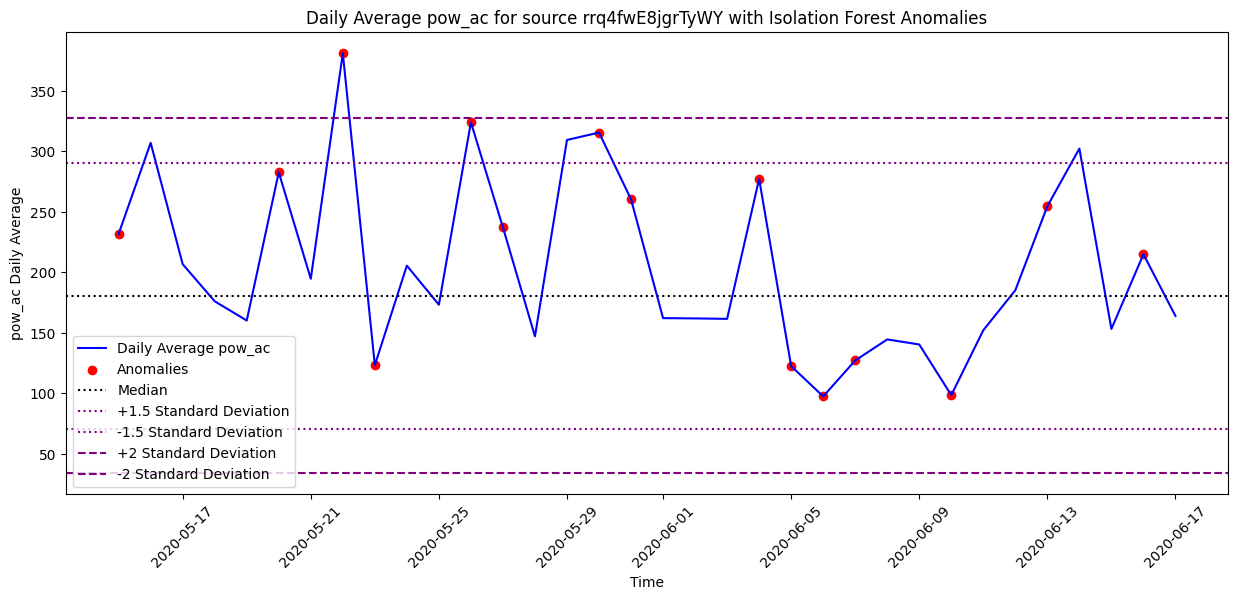

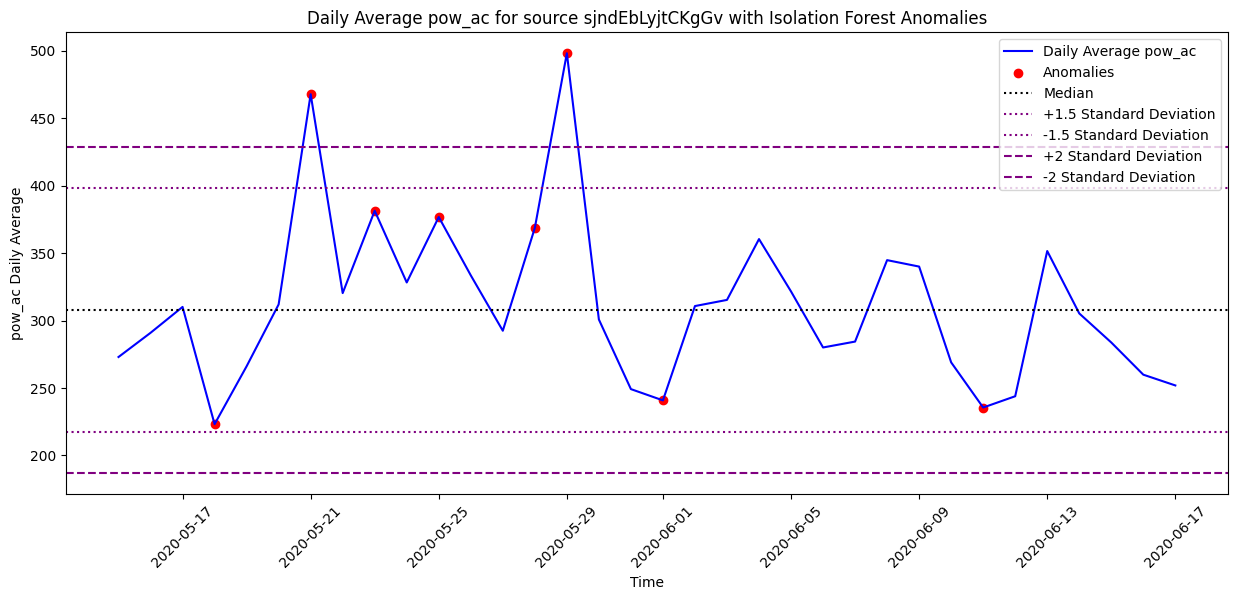

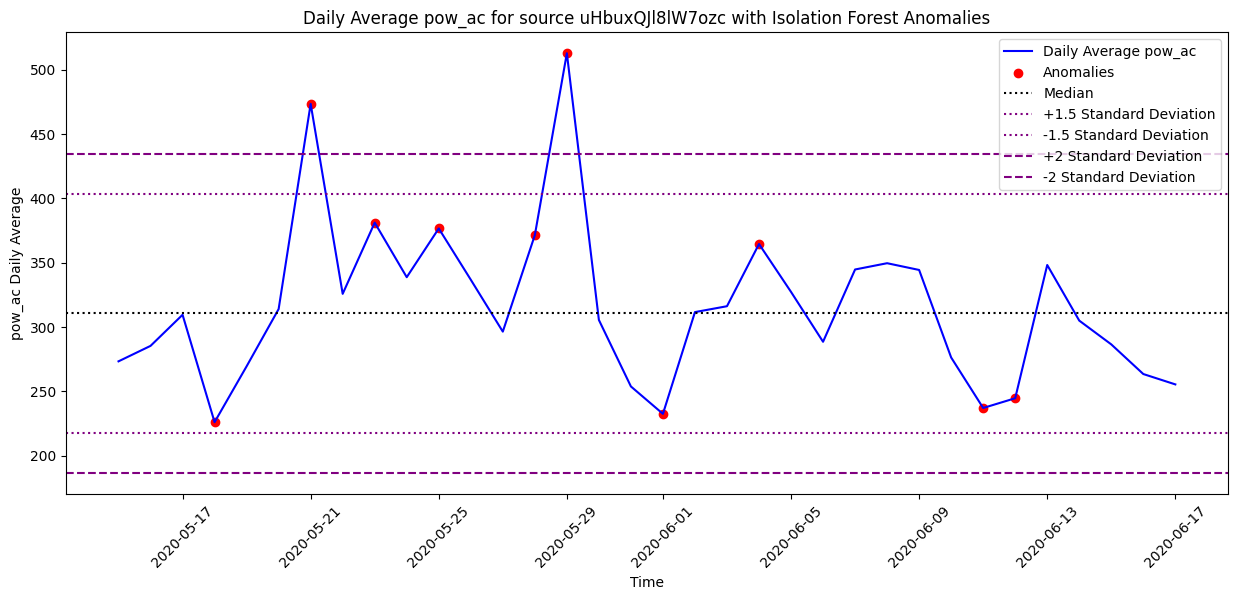

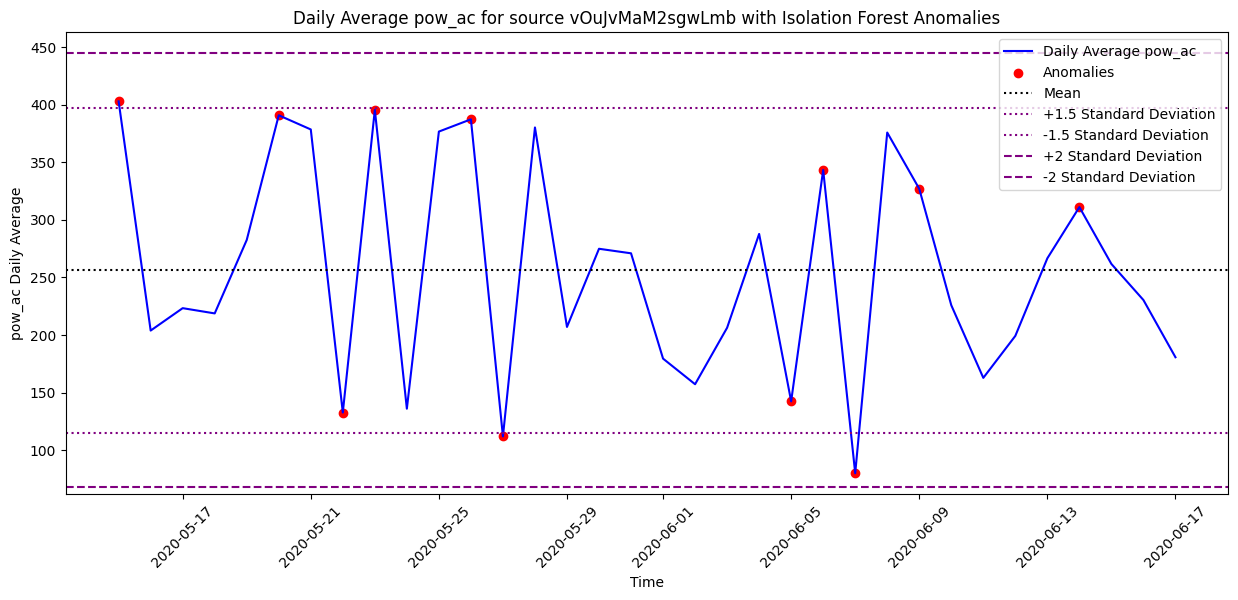

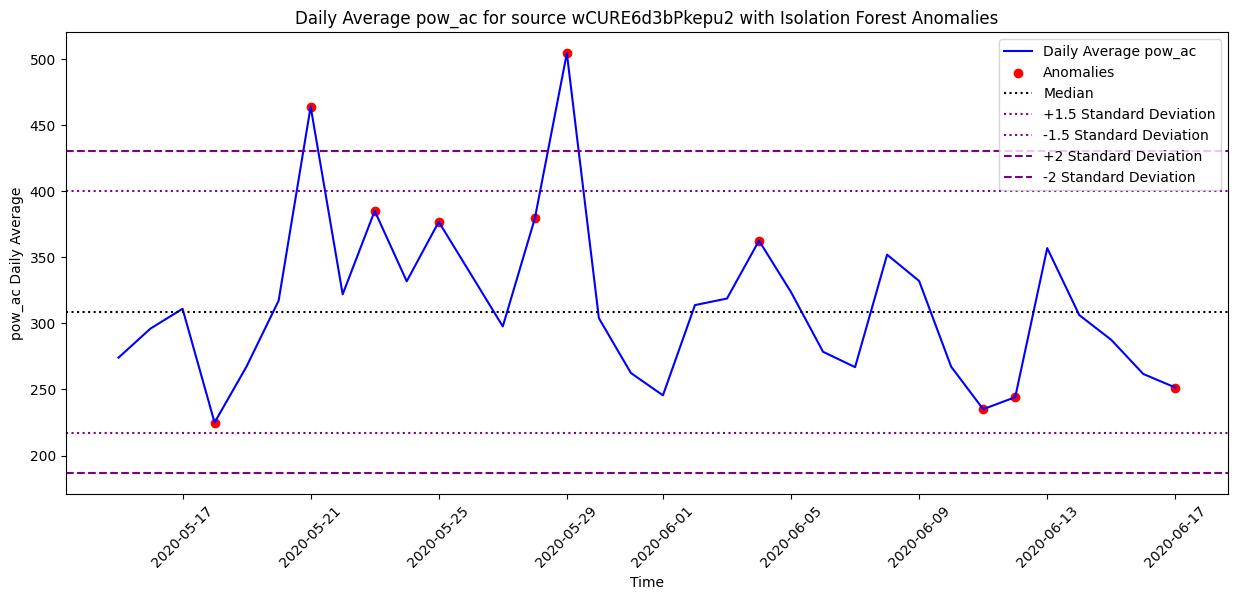

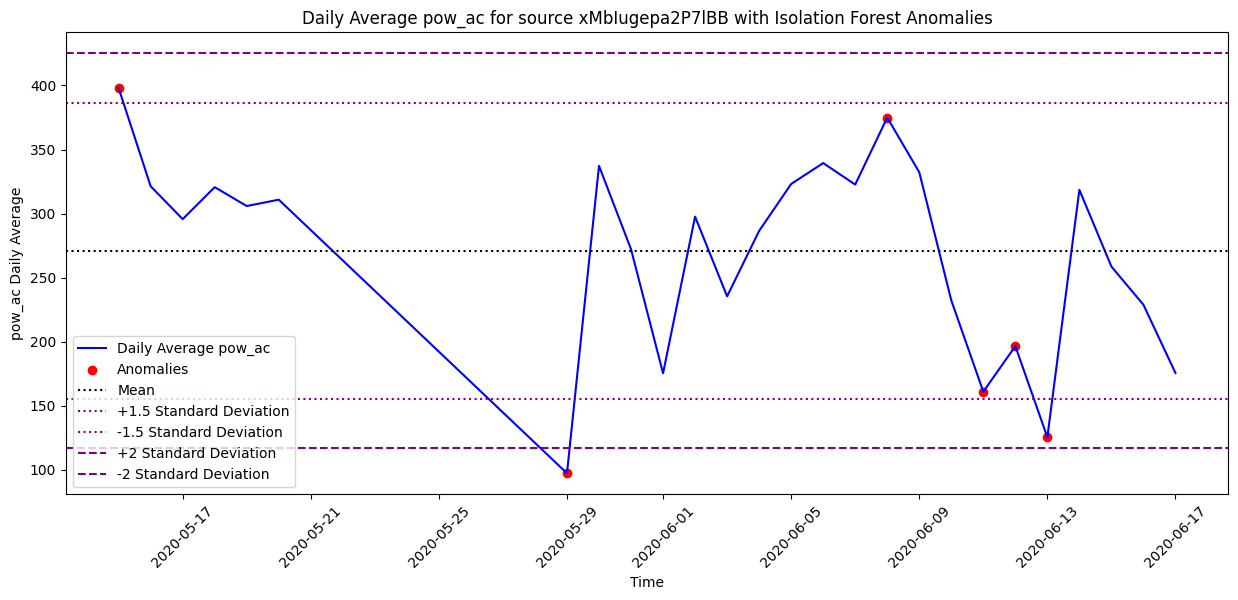

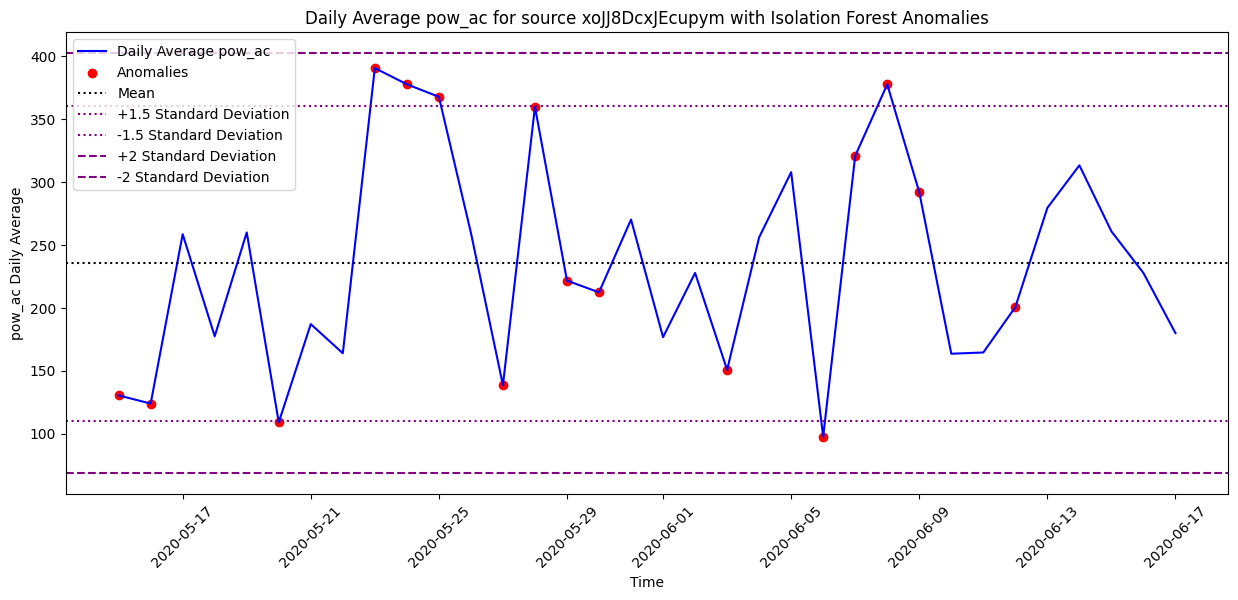

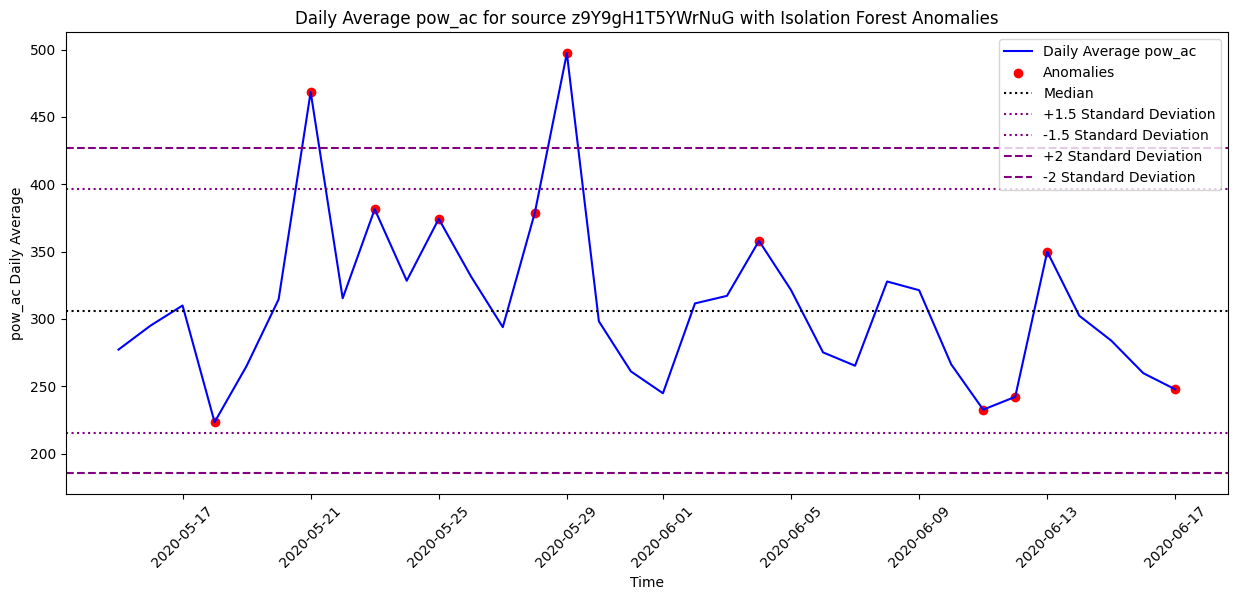

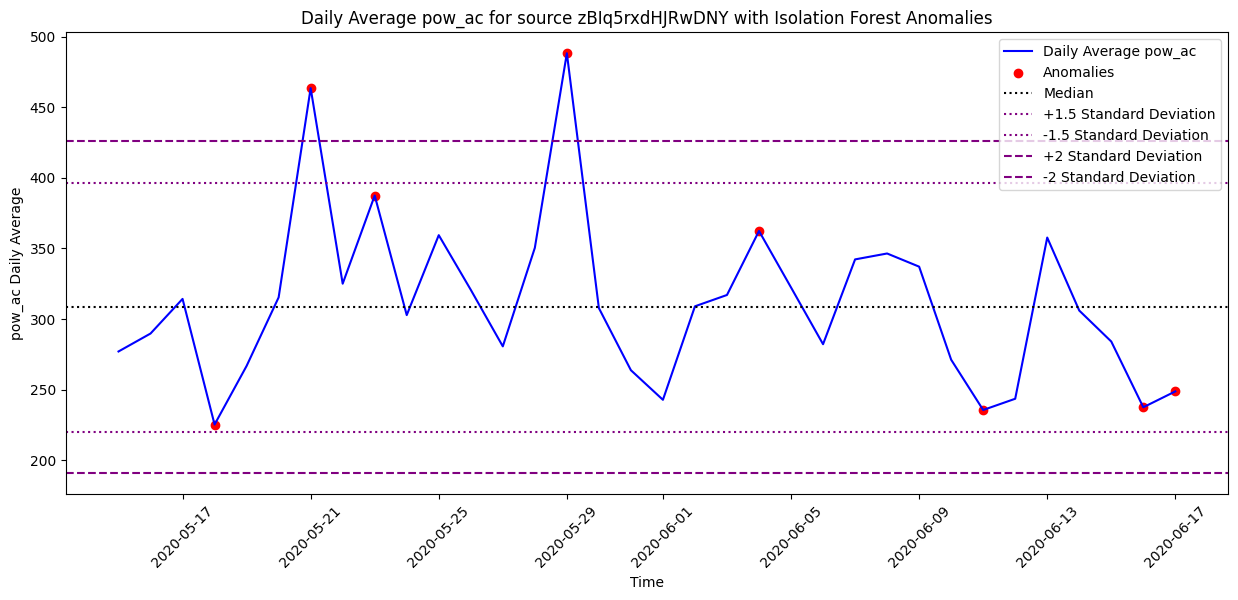

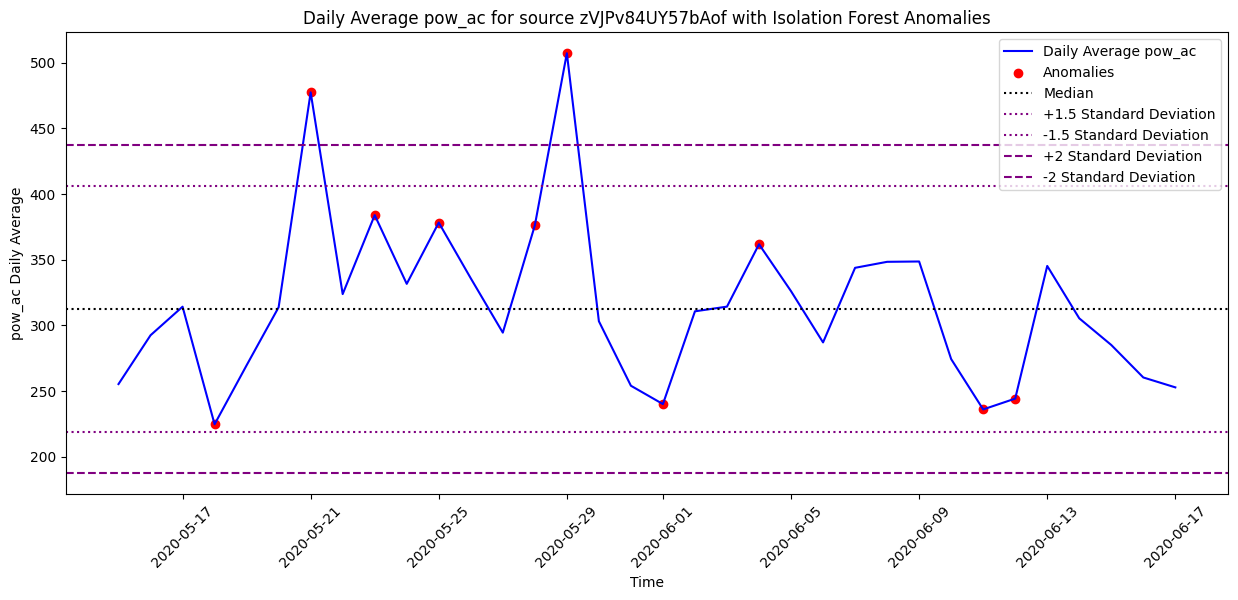

In [30]:
for source in sources:
    target = "pow_ac"

    d = df.loc[df.sourceKey == source][["dtm", target]].set_index("dtm").dropna()
    
    # Standardize data
    scaler = StandardScaler()
    target_standardized = f"{target}_standardized"
    d[target_standardized] = scaler.fit_transform(d[[target]])

    # Shapiro-Wilk Test for Normality
    stat, p = shapiro(d[target])
    alpha = 0.05
    if p > alpha:
        central_tendency = d[target].mean()
        label = "Mean"
    else:
        central_tendency = d[target].median()
        label = "Median"
    std = d[target].std()

    # Apply Isolation Forest
    clf = IsolationForest(random_state=42, contamination='auto')
    d['anomaly'] = clf.fit_predict(d[[target_standardized]])
    d['anomaly'] = d['anomaly'] == -1  # Mark anomalies as True, normal points as False

    # Plot
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=d, x=d.index, y=target, label=f"Daily Average {target}", color='blue')
    
    # Highlight anomalies
    anomaly_data = d[d['anomaly']]
    plt.scatter(anomaly_data.index, anomaly_data[target], color='red', label="Anomalies")

    # Central Tendency and Standard Deviation Lines
    plt.axhline(y=central_tendency, color="black", linestyle=":", label=label)
    plt.axhline(y=central_tendency + 1.5 * std, color="purple", linestyle=":", label="+1.5 Standard Deviation")
    plt.axhline(y=central_tendency - 1.5 * std, color="purple", linestyle=":", label="-1.5 Standard Deviation")
    plt.axhline(y=central_tendency + 2 * std, color="purple", linestyle="--", label="+2 Standard Deviation")
    plt.axhline(y=central_tendency - 2 * std, color="purple", linestyle="--", label="-2 Standard Deviation")

    plt.title(f"Daily Average {target} for source {source} with Isolation Forest Anomalies")
    plt.xlabel("Time")
    plt.ylabel(f"{target} Daily Average")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()